# Phase 3 Project

## 1. Business Problem and Understanding

[place holder for stakeholders & background info]

**The goal:** Create a model to predict churn in telecom members contacting support. We are aiming to reduce the amount of cases in which members are mistakenly identified as retained (false negative) vs mistakenly identified as churned to ensure we capture all members who may churn (positive).

In [532]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

In [210]:
# Load in csv

df = pd.read_csv('Data/tel_cust_curn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Data Exploration

The dataset has no missingness and most columns are numeric. Will have to explore the object type columns to assess whether to drop or transform. With 3333 entries, the dataset is not small but not the largest, depending on the distribution of the target, may need to consider re-sampling.

It looks like our columns names all have spaces where underscores should be so we will want to adjust that. We will note this in our *pre-split* steps.

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [211]:
# Rename columns with '_' instead of spaces

df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

It looks like we definitely have **class imbalance** and will have to address that in our preprocessing, after splitting our train/test data.

### Target Variable: `churn`

- Of the 3,333 customers in this dataset, 483 terminated their contract with SyriaTel.
- This is an imbalanced dataset, with 14.5% of customers lost. We will need to address this before modeling in our preprocessing.
- We will also label encode this variable to change it from a bool to a numeric value.

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


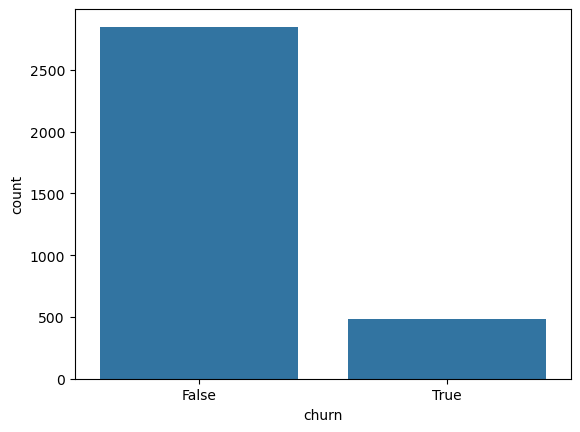

In [374]:
print(df['churn'].value_counts(normalize=True))
sns.countplot(data=df, x='churn', );

### Categorical Columns

It looks like `phone_number` is an object type, not sure we can do anything with that information as far as predictions, but we can turn it into a unique identifier for the customer. `international_plan` and `voice_main_plan` can be transformed to a binary numeric format and `state` is nominal so can be transformed to numeric as well.

In [131]:
df.select_dtypes('object')

,state,phone_number,international_plan,voice_mail_plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no
...,...,...,...,...
3328,AZ,414-4276,no,yes
3329,WV,370-3271,no,no
3330,RI,328-8230,no,no
3331,CT,364-6381,yes,no


#### `phone_number`

Since there are no duplicates, we can confidently drop the phone_number column as each row is unique.

In [369]:
print(sum(df.phone_number.value_counts().values>1))
df.drop('phone_number', axis=1, inplace=True)

0


#### `state`

This is a nominal categorical variable and can be transformed to numeric by using methods like one-hot encoding or label encoding, depending on the specific requirements of the machine learning algorithm being used. We might even consider mapping states to their respective time zones to reduce the number of variables.

In [377]:
df['state'].value_counts()

state
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: count, dtype: int64

#### `international_plan` and `voice_mail_plan`

These variables can be transformed to a binary numeric format. With no set equal to zero and yes set equal to 1. Note that there are far more customers without international and voice mail plans.

international_plan
no     0.90309
yes    0.09691
Name: proportion, dtype: float64

voice_mail_plan
no     0.723372
yes    0.276628
Name: proportion, dtype: float64


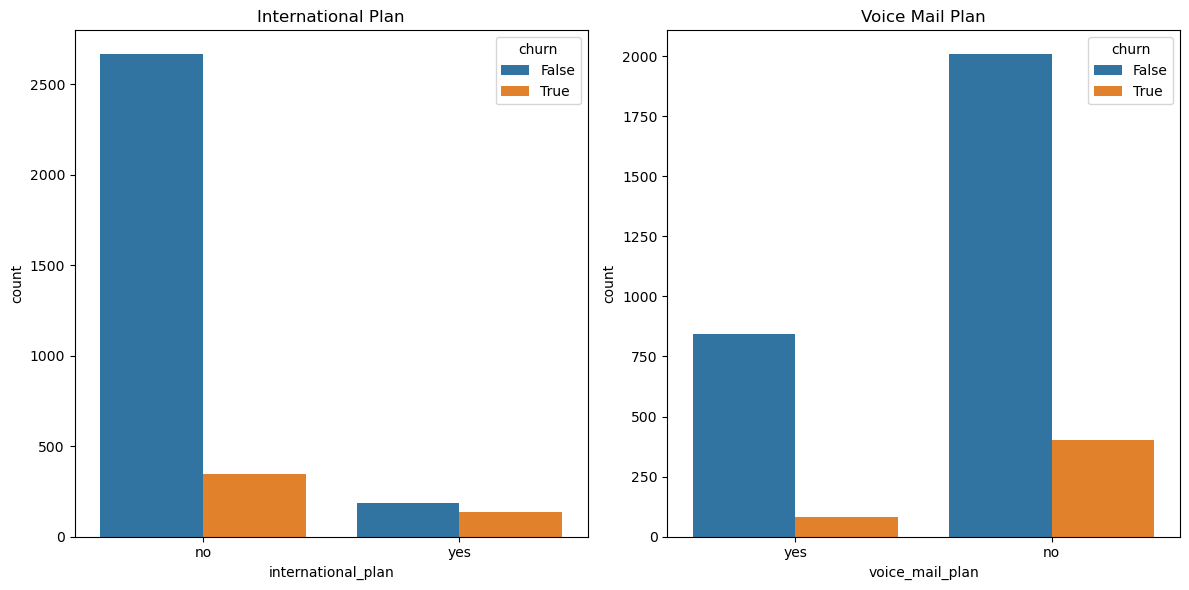

In [378]:
print(df['international_plan'].value_counts(normalize=True))
print()
print(df['voice_mail_plan'].value_counts(normalize=True))

#Histograms
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first count plot
sns.countplot(x='international_plan', hue='churn', data=df, ax=axes[0])
axes[0].set_title('International Plan')

# Plot the second count plot
sns.countplot(x='voice_mail_plan', hue='churn', data=df, ax=axes[1])
axes[1].set_title('Voice Mail Plan')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Numeric Columns

Looking at numeric datatype columns, it seems like we can consolidate certain information that seems to be telling us the same thing. Columns pertaining to minutes, calls, and charge per time of day can most likely be combined to represent each time of day by a combined metric or one of the 3 columns which best represents level of contact per time of day. This same concept can be applies to `intl` calls which it looks like represent 'international' calls.

In [132]:
df.select_dtypes('number')

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2


There seems to be very few outliers in the numeric columns. Though columns like `number_vmail_messages` and `total_day_calls` do have minimums of 0, depending on the frequency of these cases, these may need to be dropped. There is also a member who has been with the company longer than others as seen in `account_length`.

In addition, `area_code` is really a categorical variable and should be transformed after data splitting.

In [158]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## 3. Data Preperation

Before we transform columns, we will split our data into train and test sets. For our base model we will keep the train/test split as the default .75/.25 respectively. Since we know we have class imbalance, we will turn `stratify` to `True` so our class proportions stay the same for both our train and test data.

In [379]:
# Define X and y, and split train/test data
df_copy = df.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y)

### Initial Preprocessing

In [380]:
# Transform target

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('y_train')
print(y_train.value_counts(normalize=True))
print('')
print('y_test')
print(y_test.value_counts(normalize=True))

y_train
churn
0    0.855142
1    0.144858
Name: proportion, dtype: float64

y_test
churn
0    0.854916
1    0.145084
Name: proportion, dtype: float64


In [381]:
def init_processing(X):
    '''
    Initial processing, takes in train and test data.
    '''
    # transfrom y/n columns to 1/0
    X['international_plan'] = X['international_plan'].map({'yes':1,'no':0})
    X['voice_mail_plan'] = X['voice_mail_plan'].map({'yes':1,'no':0})
    # make 'state' uppercase to eliminate inconsitencies 
    X['state'] = X['state'].str.upper()
    # turn `phone_number` into int
    #X['phone_number'] = X['phone_number'].str.replace('-','').astype(int)
    return X

X_train = init_processing(X_train)
X_train

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
2965,WI,103,415,0,0,0,180.2,134,30.63,97.7,85,8.30,181.7,134,8.18,8.4,3,2.27,1
692,NE,82,408,0,0,0,185.8,36,31.59,276.5,134,23.50,192.1,104,8.64,5.7,7,1.54,4
64,NC,38,408,0,0,0,131.2,98,22.30,162.9,97,13.85,159.0,106,7.15,8.2,6,2.21,2
1005,ND,12,510,1,0,0,216.7,117,36.84,116.5,126,9.90,220.0,110,9.90,9.8,4,2.65,2
2892,DE,103,415,0,1,34,138.8,80,23.60,142.0,108,12.07,183.8,77,8.27,11.8,7,3.19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,OH,169,408,0,0,0,147.2,115,25.02,161.9,123,13.76,142.1,103,6.39,7.2,6,1.94,3
2038,TX,136,408,0,0,0,269.8,106,45.87,228.8,101,19.45,257.5,106,11.59,10.1,8,2.73,1
3300,SC,111,415,0,1,21,127.1,94,21.61,228.3,116,19.41,166.7,108,7.50,7.1,3,1.92,1
3313,ID,127,408,0,0,0,102.8,128,17.48,143.7,95,12.21,191.4,97,8.61,10.0,5,2.70,1


In [382]:
# Tranform 'state' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['state']]),columns=ohe.get_feature_names_out(['state']),index=X_train.index)
X_train.drop(columns=['state'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
2965,103,415,0,0,0,180.2,134,30.63,97.7,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
692,82,408,0,0,0,185.8,36,31.59,276.5,134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,408,0,0,0,131.2,98,22.30,162.9,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,12,510,1,0,0,216.7,117,36.84,116.5,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2892,103,415,0,1,34,138.8,80,23.60,142.0,108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,408,0,0,0,147.2,115,25.02,161.9,123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2038,136,408,0,0,0,269.8,106,45.87,228.8,101,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,415,0,1,21,127.1,94,21.61,228.3,116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3313,127,408,0,0,0,102.8,128,17.48,143.7,95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [383]:
# Tranform 'area_code' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['area_code']]),columns=ohe.get_feature_names_out(['area_code']),index=X_train.index)
X_train.drop(columns=['area_code'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
2965,103,0,0,0,180.2,134,30.63,97.7,85,8.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
692,82,0,0,0,185.8,36,31.59,276.5,134,23.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,0,0,0,131.2,98,22.30,162.9,97,13.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,12,1,0,0,216.7,117,36.84,116.5,126,9.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2892,103,0,1,34,138.8,80,23.60,142.0,108,12.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,0,0,0,147.2,115,25.02,161.9,123,13.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2038,136,0,0,0,269.8,106,45.87,228.8,101,19.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,0,1,21,127.1,94,21.61,228.3,116,19.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3313,127,0,0,0,102.8,128,17.48,143.7,95,12.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Analysis

To assess whether previously mentioned columns should be combined, we can look into the correlation between them. Looking at the heatmap below, while hard to read, we can clearly see that the state is not significantly correlated with any of the other features. Which means we can take a closer look at the features that may have a greater interaction. 

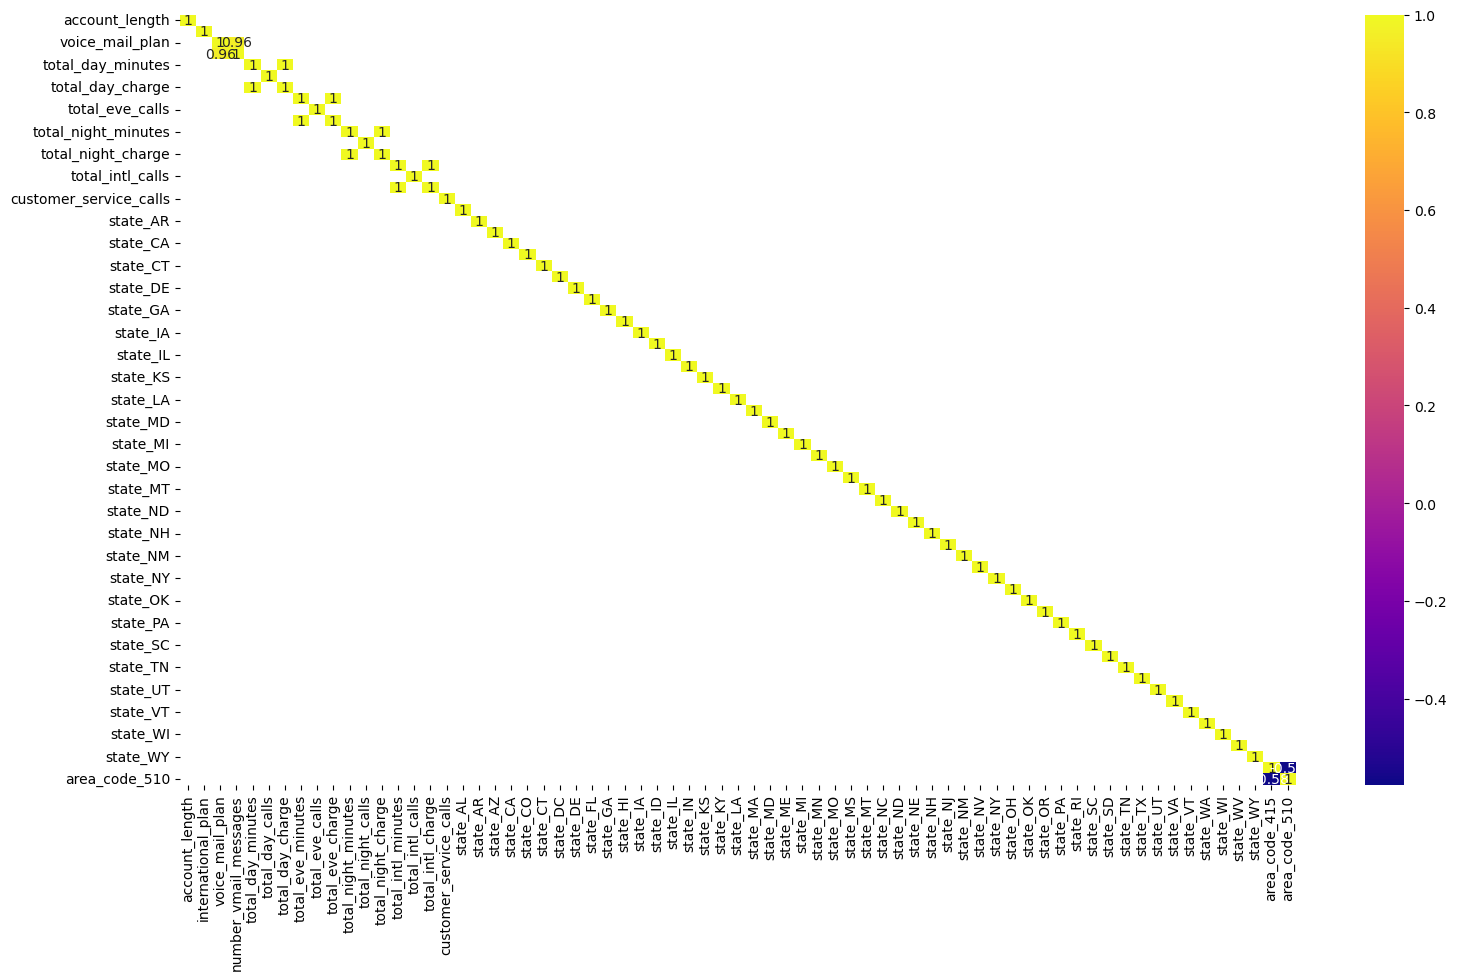

In [384]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(18,10))

corr_matrix = X_train.corr(min_periods=400)
corr_matrix = corr_matrix[corr_matrix.abs()>.1]

sns.heatmap(corr_matrix,annot=True,cmap='plasma');

We can now see clearly that charge and minutes are perfectly correlated, which makes sense if the company is charging per minute. If we need to, we can confidently drop the 'charge' column from each category; day, eve, night, and intl. We can keep the 'minutes' category as it is unclear what currency metric 'charge' is referring to.

Lastly, there is a near perfect correlation between `number_vmail_messages` and `voice_mail_plan` this makes sense and these two columns much like 'charge' and 'minutes' are telling us the same thing. If we need to, we can drop `number_vmail_messages`.

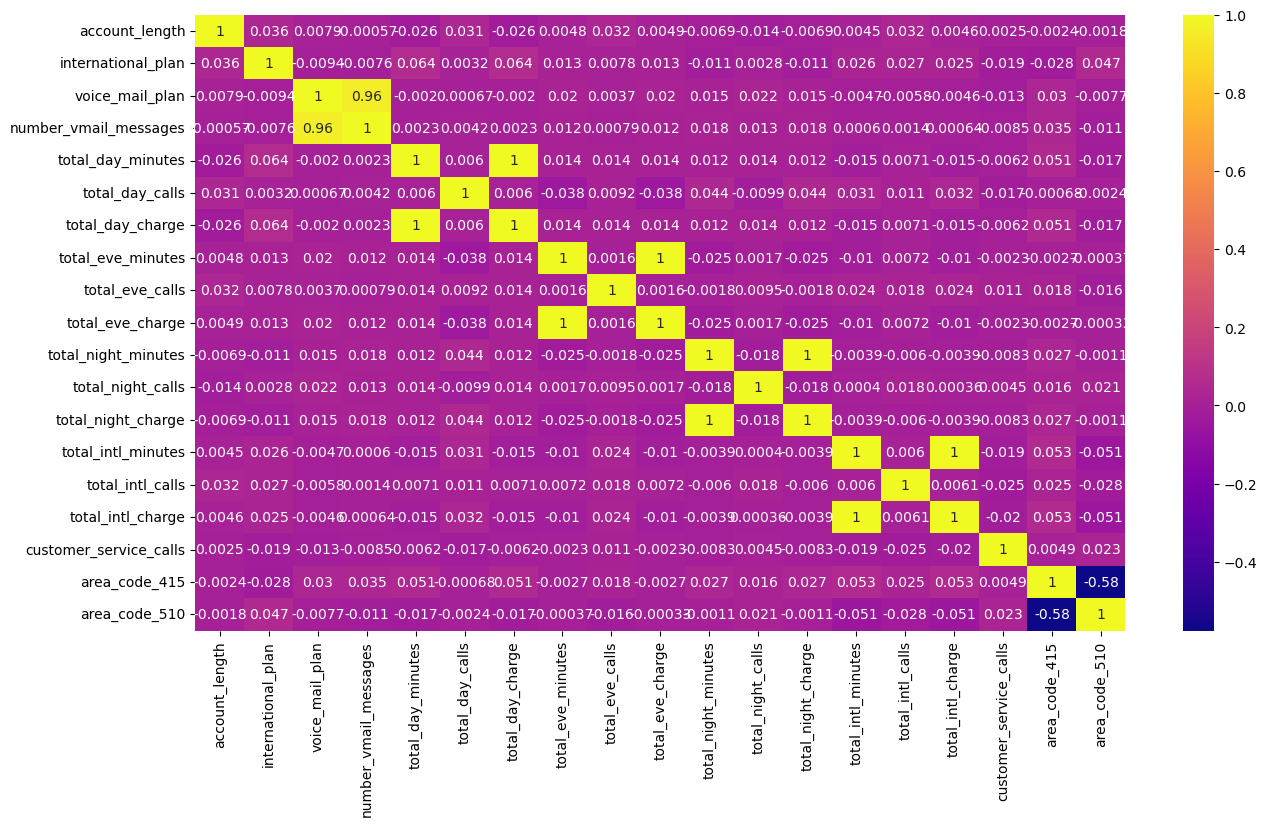

In [385]:
fig, ax = plt.subplots(figsize=(15,8))

non_state_cols = [col for col in X_train.columns if 'state' not in col]

sns.heatmap(X_train[non_state_cols].corr(min_periods=400),annot=True,cmap='plasma');

## 4. 1st Model

Give that all our features in the right format, we can build our base model with `DummyClassifier` using the `stratified` strategy since we have an imbalanced dataset skewed in the direction of class 0 when we are interested in predicting class 1.

In [535]:
base = DummyClassifier(strategy = 'stratified',random_state=42)
base.fit(X_train,y_train)

DummyClassifier(random_state=42, strategy='stratified')

### Initial `LogisticRegression` Model

To start, we will fit our data to a `LogisiticRegression` model with a `liblinear` solver so that we can potentially test both L1 and L2 penalties.

In [536]:
logreg_model = LogisticRegression(random_state=42,solver='liblinear')
logreg_model.fit(X_train,y_train)

LogisticRegression(random_state=42, solver='liblinear')

Comparing our first `LogisticRegression` model with our `base`, we can see that our `LogisticRegression` model does somewhat better at predicting `churn` with  92 TP results vs 57 with our `base`.

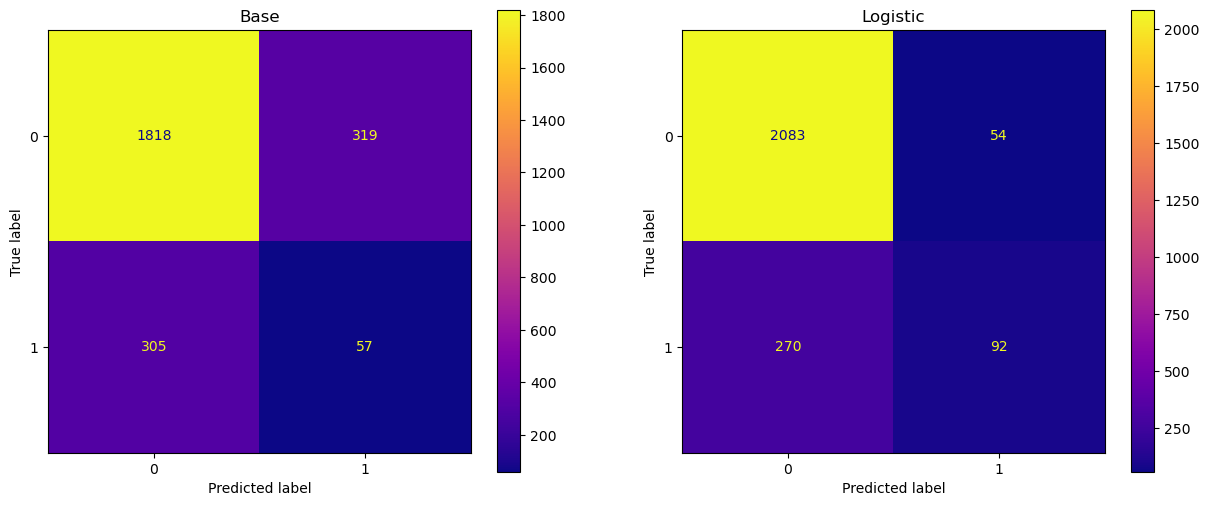

In [537]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Base')
ax[1].set_title('Logistic')

ConfusionMatrixDisplay.from_estimator(base,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[1],cmap='plasma');

Next, we can try fitting the `LogisticRegression` model with an L1 penalty.

In [538]:
logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_model_l1.fit(X_train,y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

It looks like the Logisic L1 model does better than both previous models but only slightly. However our class imbalance makes it difficult to assess accurately and needs to be addressed.

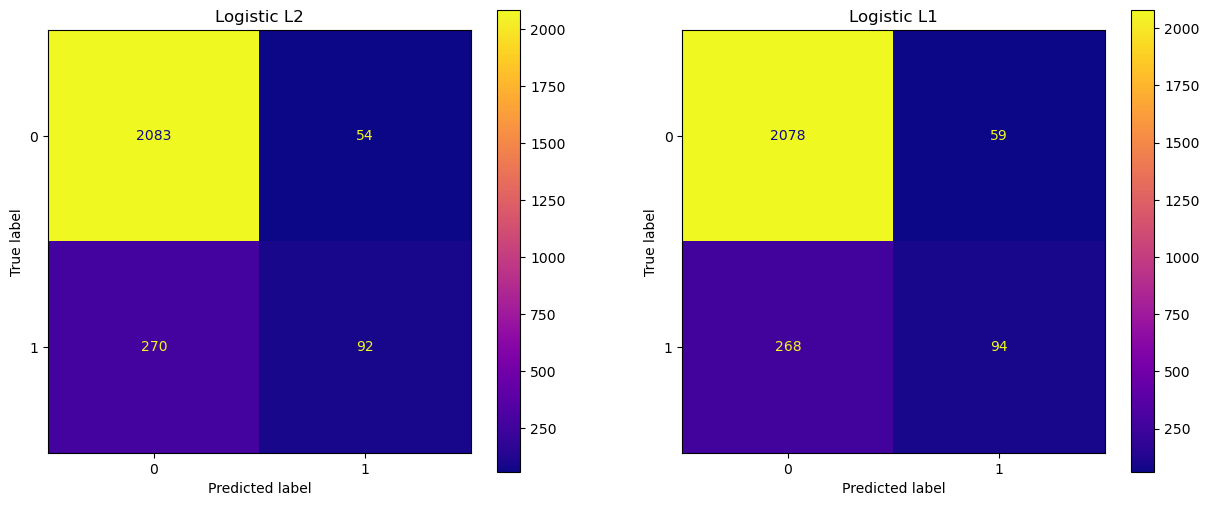

In [539]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))

ax[0].set_title('Logistic L2')
ax[1].set_title('Logistic L1')

ConfusionMatrixDisplay.from_estimator(logreg_model,X_train,y_train,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train,y_train,ax=ax[1],cmap='plasma');

### Class Imbalance with `SMOTE`

We can easily resample and even out the distribution among the classes. 

In [540]:
def Resampling(X,y):
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X,y)

    # Preview new class distribution
    print('Synthetic sample class distribution: \n')
    print(pd.Series(y_train_resampled).value_counts())
    return X_train_resampled, y_train_resampled

In [541]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

churn
0    2137
1     362
Name: count, dtype: int64
------------------------------
Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


### Finetuning `SMOTE` Ratios

After finetuning the `SMOTE` ratios, we can see that an 'even' split produces the best recall metrics so we will stick with that going forward and apply to all future models.

In [543]:
ratios = [0.2, 0.4, .5, .75, 1]
names = ['0.2','0.4','0.5','0.75','even']
colors = sns.color_palette('pastel')


for n, ratio in enumerate(ratios):
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resamp_tune, y_train_resamp_tune= smote.fit_resample(X_train,y_train)
    logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=1000)
    logreg_model_l1 = logreg_model_l1.fit(X_train_resamp_tune, y_train_resamp_tune) 
    print('Synthetic Ratio: {}'.format(names[n]))

    # Cross validate
    scores = cross_val_score(logreg_model_l1,X_train_resamp_tune, y_train_resamp_tune,scoring='recall')
    print('With average recall score: {}\n'.format(scores.mean()))
    
    

Synthetic Ratio: 0.2
With average recall score: 0.2529138166894665

Synthetic Ratio: 0.4
With average recall score: 0.48476092191262465

Synthetic Ratio: 0.5
With average recall score: 0.5739502435171778

Synthetic Ratio: 0.75
With average recall score: 0.7222410436137071

Synthetic Ratio: even
With average recall score: 0.794569808925562



### Finetuning Max Iterations

Since we had to had to increase our max iterations for the Logistic model, but have found that it does not impact our recall so we can keep to the min required at 200.

0 LogisticRegression(max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.7950239663814047

1 LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.7950239663814047

2 LogisticRegression(max_iter=400, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.7950239663814047

3 LogisticRegression(max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

With average recall score: 0.7950239663814047



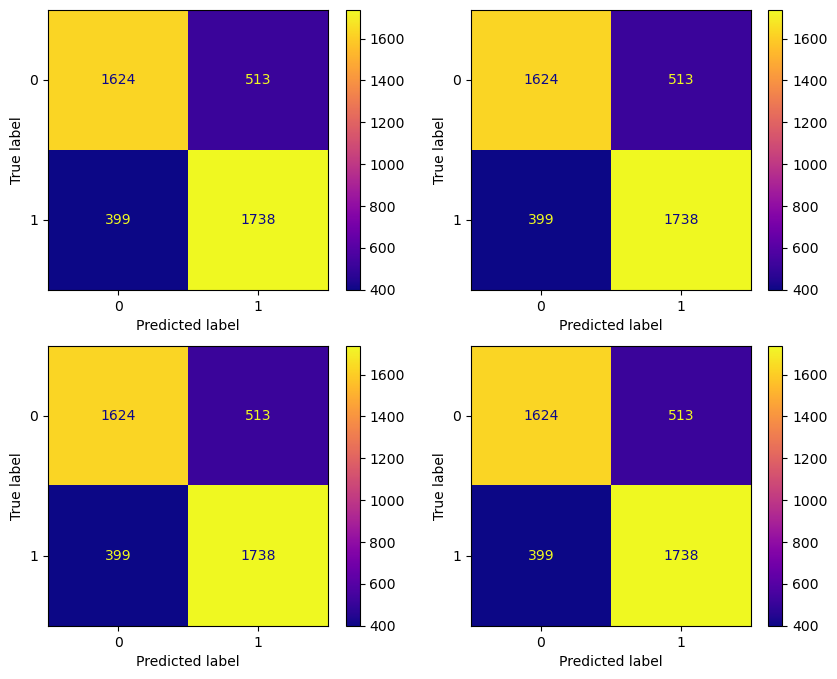

In [544]:
iterations = [200, 300, 400, 500]

ax, fig = plt.subplots(ncols=2,nrows=2,figsize=(10,8))

axes = ax.get_axes()

for i, iter in enumerate(iterations):
    logreg_model_l1 = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=iter)
    logreg_model_l1 = logreg_model_l1.fit(X_train_resampled,y_train_resampled) 
    print(i, logreg_model_l1)
    print()
    scores = cross_val_score(logreg_model_l1,X_train_resampled,y_train_resampled,scoring='recall')
    print('With average recall score: {}\n'.format(scores.mean()))

    ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train_resampled,y_train_resampled,
                                          ax=axes[i],cmap='plasma')

### Cross Validation

Now we have cross validated our results to finalize our 1st model with `LogisiticRegression`. It looks like our model performs slightly better on the test data. We can probably get this even higher after we simplify our model some more.

In [648]:
def cross_val(model,X,y,kfolds=10):
    
    train_scores = []
    test_scores = []

    cv_results = cross_validate(model,X,y,scoring='recall',return_train_score=True,cv=kfolds)
    
    train_score_mean = cv_results['train_score'].mean()
    test_score_mean = cv_results['test_score'].mean()

    print('Test score avg: {}'.format(train_score_mean))
    print('Train score avg: {}'.format(test_score_mean))

In [649]:
cross_val(logreg_model_l1, X_train_resampled, y_train_resampled)

Test score avg: 0.8112617207390999
Train score avg: 0.8006713176253782


### Model with Cross Validation

In [643]:
class ModCrossVal():
    '''Create model and see the crossvalidation more easily'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
    
        # For CV results
        self.kfolds = None
        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None
    
        if cv_now:
            self.cross__val()
    
    def cross__val(self,X=None,y=None, kfolds=10):
        '''
        Perform cross validation and return results.
    
        Args:
         X:
          Optional; Training data to perform CV on. Otherwise use X from object
         y:
          Optional; Training data to perform CV on. Otherwise use y from object
         kfolds:
          Optional; Number of folds for CV (default is 8)  
        '''
    
        cv_X = X if X else self.X
        cv_y = y if y else self.y
        self.kfolds=kfolds
    
        self.cv_results = cross_validate(self.model,cv_X,cv_y,scoring='recall',return_train_score=True,cv=kfolds)
        self.cv_train_mean = np.mean(self.cv_results['train_score'])
        self.cv_test_mean = np.mean(self.cv_results['test_score'])
    
    def cv_summary(self):
        
        summary = {
            'name':self.name,'kfolds':self.kfolds,'cv_train_mean':self.cv_train_mean,'cv_test_mean':self.cv_test_mean}
    
        cv_summary = pd.DataFrame(summary,columns=[self.name, 'kfolds','cv_train_mean','cv_test_mean'],index=range(1))
        return cv_summary

In [644]:
test = ModCrossVal(logreg_model_l1, "Logistic L1", X_train_resampled, y_train_resampled)

In [645]:
test.cv_summary()

,Logistic L1,kfolds,cv_train_mean,cv_test_mean
0,NaN,10,0.811262,0.800671


In [393]:
# may use this later

scaler = StandardScaler()


StandardScaler()

In [410]:
def scale_values(X, scaler):
    '''
    Takes DataFrame and fitted scaler as input.
    '''
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled,columns=X.columns,index=X.index)
    return X_scaled

In [650]:
X_train_scaled = scale_values(X_train_resampled,scaler)
X_train_scaled.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
0,0.047680,-0.321421,-0.620689,-0.594195,0.003946,1.682382,0.003448,-2.026492,-0.752785,-2.027594,...,-0.144338,-0.147201,-0.152779,-0.148613,-0.139942,6.375735,-0.180678,-0.154145,0.998001,-0.57504
1,-0.479760,-0.321421,-0.620689,-0.594195,0.107169,-3.252032,0.107539,1.507305,1.721096,1.506683,...,-0.144338,-0.147201,-0.152779,-0.148613,-0.139942,-0.156845,-0.180678,-0.154145,-1.002003,-0.57504
2,-1.584873,-0.321421,-0.620689,-0.594195,-0.899251,-0.130260,-0.899758,-0.737882,-0.146937,-0.737118,...,-0.144338,-0.147201,-0.152779,-0.148613,-0.139942,-0.156845,-0.180678,-0.154145,-1.002003,-0.57504
3,-2.237894,3.111187,-0.620689,-0.594195,0.676736,0.826412,0.676786,-1.654930,1.317197,-1.655565,...,-0.144338,-0.147201,-0.152779,-0.148613,-0.139942,-0.156845,-0.180678,-0.154145,-1.002003,1.73901
4,0.047680,-0.321421,1.611112,1.893308,-0.759163,-1.036581,-0.758801,-1.150949,0.408425,-1.151000,...,-0.144338,-0.147201,-0.152779,-0.148613,-0.139942,-0.156845,-0.180678,-0.154145,0.998001,-0.57504


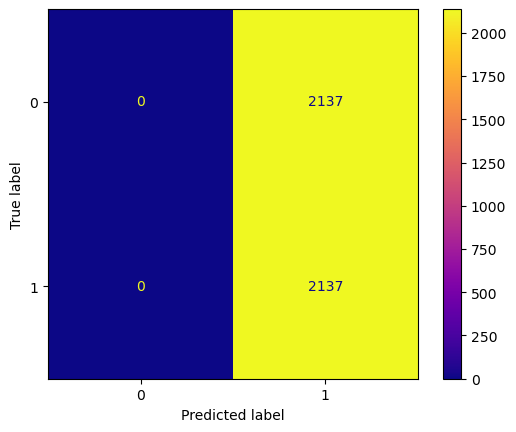

In [652]:
logreg_scaled = LogisticRegression(random_state=42,solver='liblinear',penalty='l1')
logreg_scaled.fit(X_train_scaled,y_train_resampled)

ConfusionMatrixDisplay.from_estimator(logreg_scaled,X_train_resampled,y_train_resampled,cmap='plasma');

## 5. 2nd Model

Since we had a few columns that were directly correlated we will try simplifying the model to see if this improves our results.

In [533]:
X_train_reduced = X_train.drop(columns=['number_vmail_messages', 'total_day_charge', 'total_eve_charge', 
                                        'total_night_charge', 'total_intl_charge'], axis=1,)


X_train_resamp_reduced, y_train_resamp_reduced = Resampling(X_train_reduced,y_train)

Synthetic sample class distribution: 

churn
0    2137
1    2137
Name: count, dtype: int64


In [534]:
# Run new reduced model with the same parameters

logreg_reduced = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=200)
logreg_reduced = logreg_reduced.fit(X_train_resamp_reduced, y_train_resamp_reduced)

### Cross Validate 2nd Model

It looks like our model did slightly worse than before eliminating these columns. It would be interesting to use `SelectFromModel` to see if reducing features by weight is more appropriate.

In [627]:
cross_val(logreg_reduced,X_train_resampled,y_train_resampled)

Test score avg: 0.8098576859404455
Train score avg: 0.7945691937977376


### Feature Selection with `SelectFromModel`

In [547]:
selector = SelectFromModel(logreg_model_l1)

# Using the original resampling from first SMOTE initiation
selector.fit(X_train_resampled,y_train_resampled)

SelectFromModel(estimator=LogisticRegression(max_iter=500, penalty='l1',
                                             random_state=42,
                                             solver='liblinear'))

We will use the default threshold to start and identify which features meet threshold requirements. Since we are still using our L1 Logistic model, the default threshold will be $1e^-5$.

In [549]:
thresh = selector.threshold_
print(thresh)

# Extract coef
coefs = selector.estimator_.coef_
coefs

1e-05

It looks like 8 features do not meet the threshold, this is more than the amount of columns we had dropped when starting to create this 2nd model.

In [555]:
# Check shapes and initate support to 

print(coefs.shape)
print(X_train_resampled.shape)
sup = selector.get_support()

unique, counts = np.unique(sup,return_counts=True)

# Print as array to see count of features that do not meet the threshold
print(np.asarray((unique,counts)).T)

(1, 69)
(4274, 69)
[[ 0  8]
 [ 1 61]]


In [556]:
# Create dictionary matching results with features

dict(zip(X_train_resampled.columns,selector.get_support()))

{'account_length': True,
 'international_plan': True,
 'voice_mail_plan': True,
 'number_vmail_messages': True,
 'total_day_minutes': True,
 'total_day_calls': True,
 'total_day_charge': True,
 'total_eve_minutes': True,
 'total_eve_calls': True,
 'total_eve_charge': False,
 'total_night_minutes': True,
 'total_night_calls': True,
 'total_night_charge': False,
 'total_intl_minutes': True,
 'total_intl_calls': True,
 'total_intl_charge': False,
 'customer_service_calls': True,
 'state_AL': True,
 'state_AR': True,
 'state_AZ': True,
 'state_CA': True,
 'state_CO': False,
 'state_CT': True,
 'state_DC': False,
 'state_DE': True,
 'state_FL': True,
 'state_GA': True,
 'state_HI': True,
 'state_IA': True,
 'state_ID': False,
 'state_IL': True,
 'state_IN': True,
 'state_KS': True,
 'state_KY': True,
 'state_LA': True,
 'state_MA': True,
 'state_MD': True,
 'state_ME': True,
 'state_MI': True,
 'state_MN': True,
 'state_MO': True,
 'state_MS': True,
 'state_MT': True,
 'state_NC': False,
 '

In [558]:
# Create function to get best features out

def select_features(X,selector):
    '''
    Given a dataframe and selector, use the selector
    to get the most important features.
    '''
    imp_feat = dict(zip(X.columns,selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,columns=[col for col in X.columns if imp_feat[col]],
                              index = X.index)
    return selected_df

In [559]:
X_train_resamp_slct = select_features(X=X_train_resampled,selector=selector)
X_train_resamp_slct

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_night_minutes,...,state_TN,state_TX,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510
0,103.0,0.0,0.0,0.0,180.200000,134.0,30.630000,97.700000,85.0,181.700000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000
1,82.0,0.0,0.0,0.0,185.800000,36.0,31.590000,276.500000,134.0,192.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,38.0,0.0,0.0,0.0,131.200000,98.0,22.300000,162.900000,97.0,159.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,12.0,1.0,0.0,0.0,216.700000,117.0,36.840000,116.500000,126.0,220.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
4,103.0,0.0,1.0,34.0,138.800000,80.0,23.600000,142.000000,108.0,183.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,89.0,0.0,0.0,0.0,254.540356,110.0,43.273376,186.893905,96.0,157.406182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242273,0.000000
4270,114.0,0.0,0.0,0.0,163.491340,72.0,27.796138,180.599166,94.0,165.052085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.305324,0.000000
4271,127.0,0.0,0.0,0.0,141.233744,119.0,24.013575,226.686648,111.0,144.877583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
4272,104.0,0.0,0.0,11.0,159.866645,113.0,27.174861,114.689180,95.0,237.118955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000


#### Run and Cross Validate

Now we can run our cross validation again to see how it does in comparison to the other model and it's own validation set.

In [561]:
logreg_slct = LogisticRegression(random_state=42,solver='liblinear',penalty='l1',max_iter=200)
logreg_slct.fit(X_train_resamp_slct,y_train_resampled)

LogisticRegression(max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

It looks like our selected feature model did better than our reduced model. It did about the same as our `logreg_model_l1` model. But since it is simplified and will run smoother, we can consider it better.

In [632]:
cross_val(logreg_model_l1, X_train_resampled, y_train_resampled)

Test score avg: 0.8098576859404455
Train score avg: 0.7945691937977376


In [628]:
cross_val(logreg_slct, X_train_resamp_slct,y_train_resampled)

Test score avg: 0.8095457281932805
Train score avg: 0.795037577872679


### Compare Confusion Matricies

It looks like our 1st model pre-feature selection does as well as our model where we used `SelectFromModel`. 

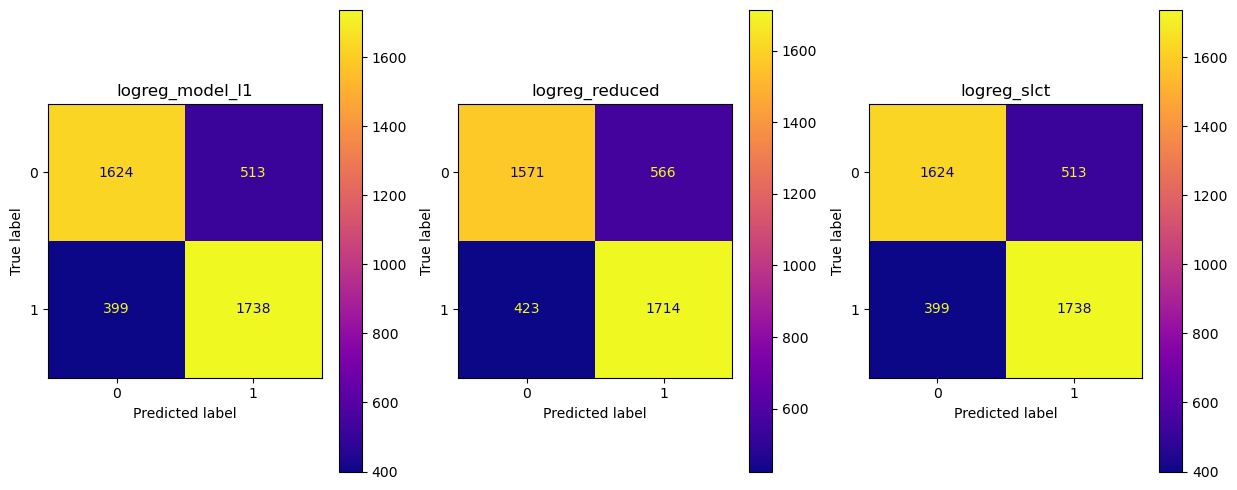

In [629]:
fig, ax = plt.subplots(ncols=3,figsize=(15,6))

ax[0].set_title('logreg_model_l1')
ax[1].set_title('logreg_reduced')
ax[2].set_title('logreg_slct')

ConfusionMatrixDisplay.from_estimator(logreg_model_l1,X_train_resampled,y_train_resampled,ax=ax[0],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_reduced,X_train_resamp_reduced,y_train_resamp_reduced,ax=ax[1],cmap='plasma')
ConfusionMatrixDisplay.from_estimator(logreg_slct,X_train_resamp_slct,y_train_resampled,ax=ax[2],cmap='plasma');